# Importing Libraries & Loading Datasets :

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import json


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'whitegrid')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## Overview Of Datasets :
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [2]:
# read in the json files
portfolio = pd.read_json('C:/Users/HP/Documents/Starbucks_Capstone_Project/Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('C:/Users/HP/Documents/Starbucks_Capstone_Project/Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('C:/Users/HP/Documents/Starbucks_Capstone_Project/Data/transcript.json', orient='records', lines=True)

## Data Exploration

#### a) portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head() # look into portfolio df

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.shape # get shape of portfolio

(10, 6)

In [5]:
portfolio.describe() # describe portfolio df

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [7]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [8]:
# Count channels
channels = portfolio.channels.explode().unique() #create a flat list of all individual channel names, then finds unique ones
channel_counts = dict()

#to count how many times that channel appears across all lists in portfolio.channels.
#store the count in channel_counts, where the keys are the channel names, and the values are their counts
for channel in channels:
    channel_counts[channel] = portfolio.channels.str.contains(channel, regex=False).sum()

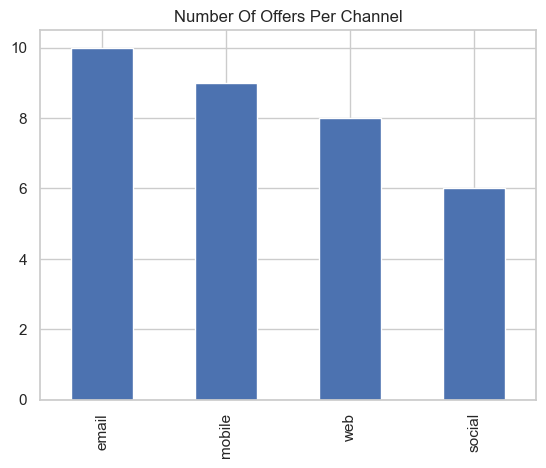

In [9]:
# Plot number of offers per channel
plt.title("Number Of Offers Per Channel")
pd.Series(channel_counts).sort_values(ascending=False).plot(kind='bar')
plt.show()

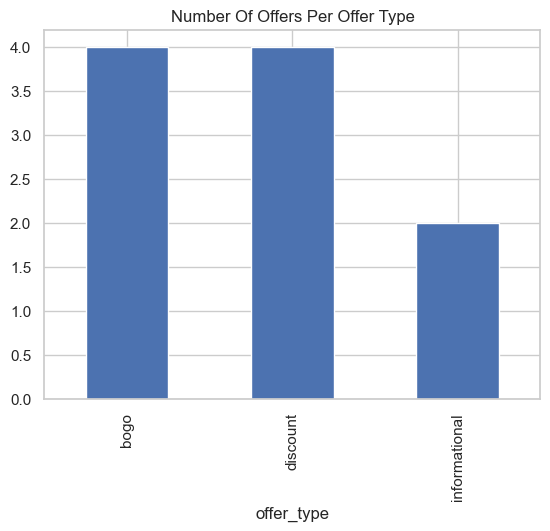

In [10]:
# Plot number of offers per offer type
plt.title("Number Of Offers Per Offer Type")
portfolio.offer_type.value_counts().plot(kind='bar')
plt.show()

In [11]:
""" The different channels as well as the offer types need to be represented differently for analysis. 
    so should Convert categorical variable into indicator variables. """

# clean channels
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).groupby(level=0).sum()

portfolio = pd.concat([portfolio, channels], axis=1)
# drop column channel
portfolio.drop(['channels'], axis=1, inplace=True)
portfolio['offer'] = (portfolio['offer_type'] + "_" + portfolio['reward'].astype('str')
                          + "_for_" + portfolio['difficulty'].astype('str') + "_in_"
                          + portfolio['duration'].astype('str') + "days")
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_for_10_in_7days
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_for_10_in_5days
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_for_0_in_4days
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_for_5_in_7days
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_for_20_in_10days
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_for_7_in_7days
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_for_10_in_10days
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_for_0_in_3days
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_for_5_in_5days
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_for_10_in_7days


In [12]:
# clean offer types -- lets make sepearte column for each offer type which is a boolean value
offer_types = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, offer_types], axis=1)
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,offer,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_for_10_in_7days,True,False,False
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_for_10_in_5days,True,False,False
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_for_0_in_4days,False,False,True
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_for_5_in_7days,True,False,False
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_for_20_in_10days,False,True,False
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_for_7_in_7days,False,True,False
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_for_10_in_10days,False,True,False
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_for_0_in_3days,False,False,True
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_for_5_in_5days,True,False,False
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_for_10_in_7days,False,True,False


#### profile.json

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [13]:
profile.head() # look into profile df

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile.describe() # desribe profile df

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
profile.shape

(17000, 5)

In [17]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [18]:
profile.duplicated().sum()

0

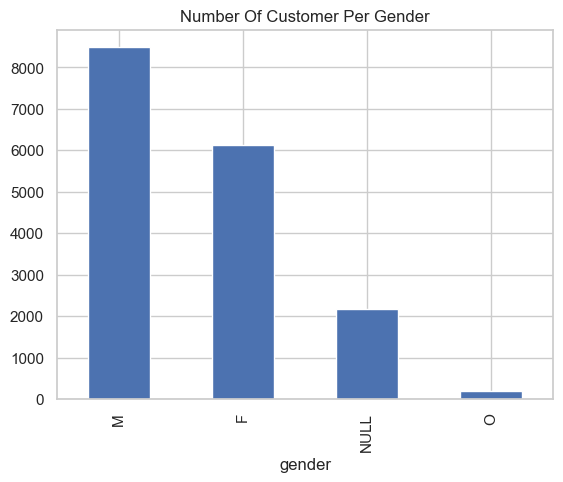

In [19]:
plt.title("Number Of Customer Per Gender")
profile.gender.fillna('NULL').value_counts().plot(kind='bar')
plt.show()

In [20]:
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head(7)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN


In [21]:
profile.dropna(inplace=True)

In [22]:
# Ensure 'became_member_on' is in datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Calculate membership duration in days
profile['membership_duration'] = (datetime.datetime.today() - profile['became_member_on']).dt.days

# Display the result
profile.head(7)

,gender,age,id,became_member_on,income,membership_duration
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2673
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2740
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2388
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2464
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2554
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,2615
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,3921


In [23]:
profile = profile.rename(columns = {'id': 'customer_id'})
columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on', 'membership_duration']
profile = profile.reindex(columns = columns_order)
profile = profile.reset_index(drop=True)
profile.head()

,customer_id,gender,age,income,became_member_on,membership_duration
0,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,2017-07-15,2673
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,2740
2,e2127556f4f64592b11af22de27a7932,M,68,70000.0,2018-04-26,2388
3,389bc3fa690240e798340f5a15918d5c,M,65,53000.0,2018-02-09,2464
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,2017-11-11,2554


The distribution plot of their income and age on their genders needs to be explored and visualized. for this, can write a function plot_profile() to reduce repeating code of writing 3 times.

In [24]:
def plot_profile(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    ''' 
    sns.set(style = 'whitegrid', font_scale = 1.25)
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)
    
    plt.sca(ax[0])
    sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
    plt.title('Female\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[df['gender'] == 'M'][variable], bins = 10, color = palette[1]);
    plt.title('Male\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')

    plt.sca(ax[2])
    sns.distplot(df[df['gender'] == 'O'][variable], bins = 10, color = palette[2]);
    plt.title('Other\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.show()
    
    return plt

C:\Users\HP\AppData\Local\Temp\ipykernel_15376\2495485367.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
C:\Users\HP\AppData\Local\Temp\ipykernel_15376\2495485367.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['

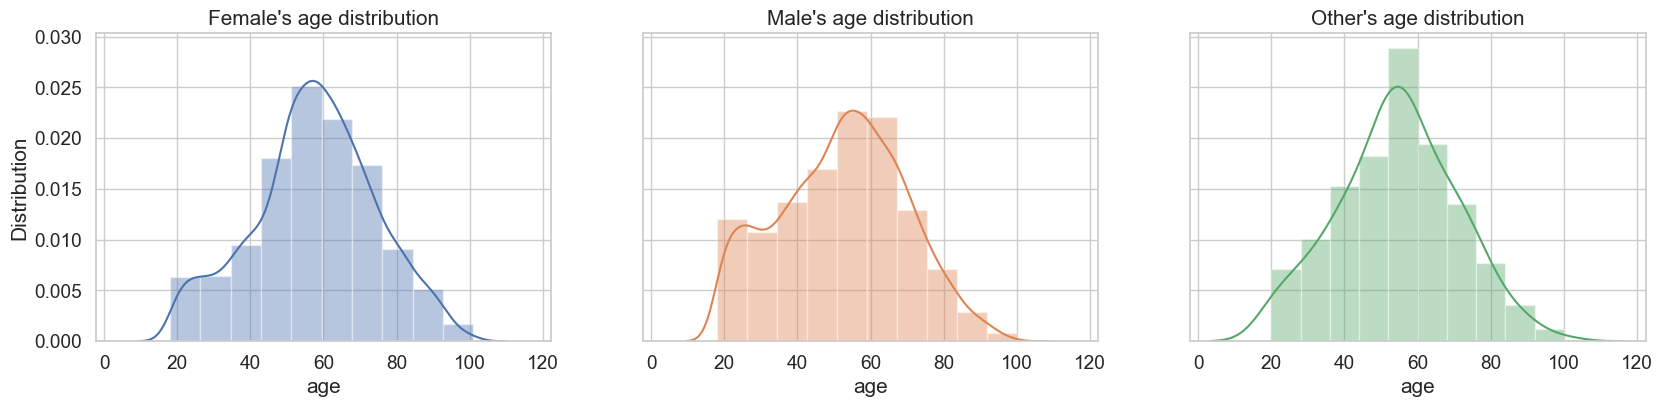

In [25]:
age_plot = plot_profile(profile, 'age')

C:\Users\HP\AppData\Local\Temp\ipykernel_15376\2495485367.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
C:\Users\HP\AppData\Local\Temp\ipykernel_15376\2495485367.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['

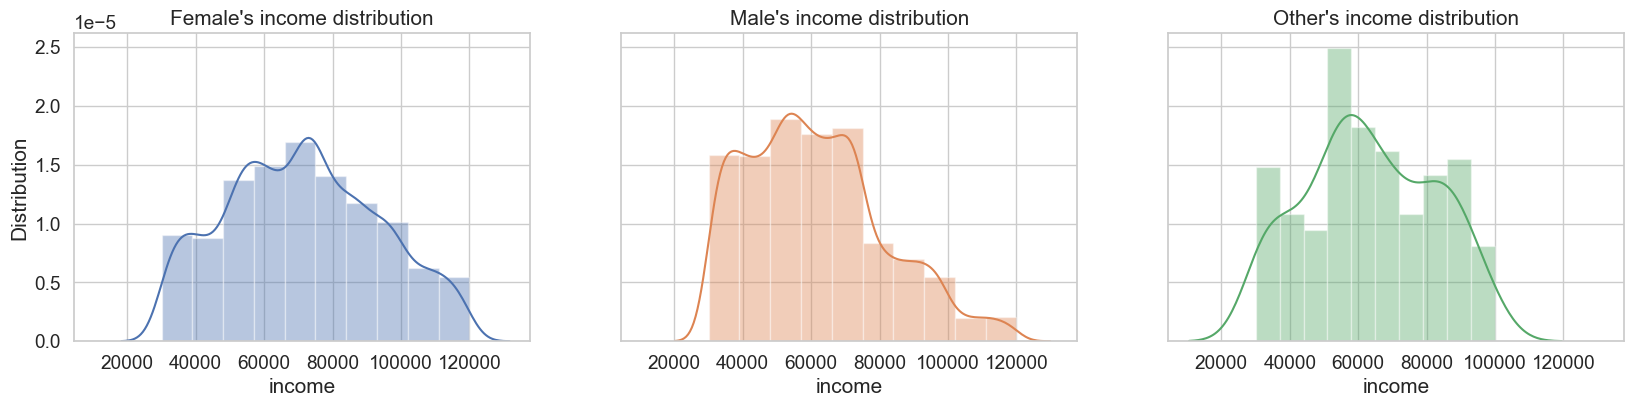

In [26]:
income_plot = plot_profile(profile, 'income')

C:\Users\HP\AppData\Local\Temp\ipykernel_15376\2495485367.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
C:\Users\HP\AppData\Local\Temp\ipykernel_15376\2495485367.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['

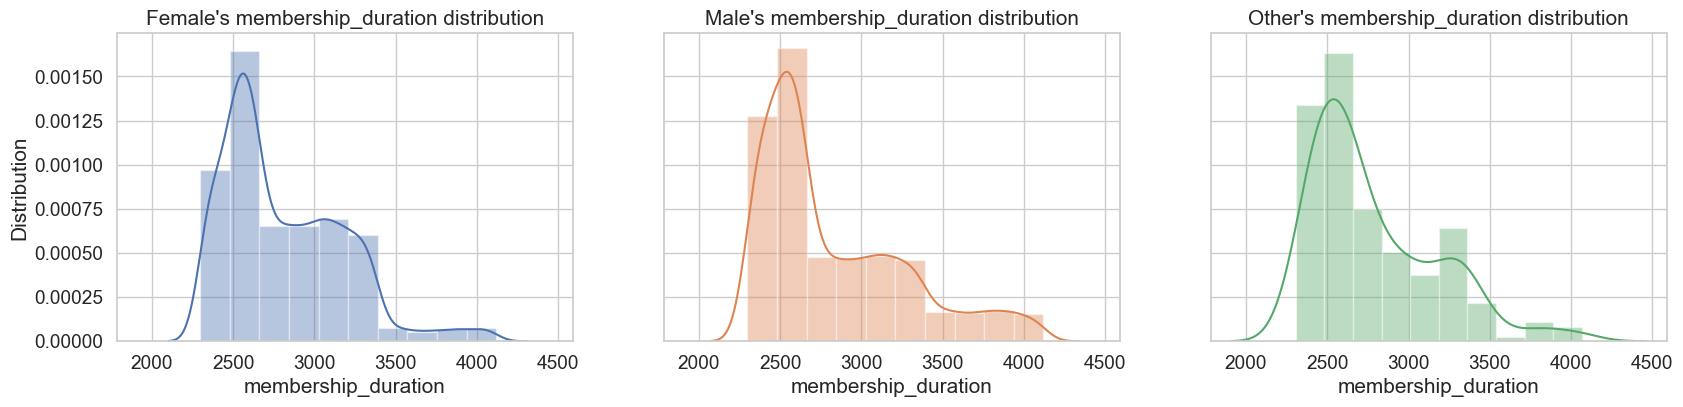

In [27]:
membership_duration_plot = plot_profile(profile, 'membership_duration')

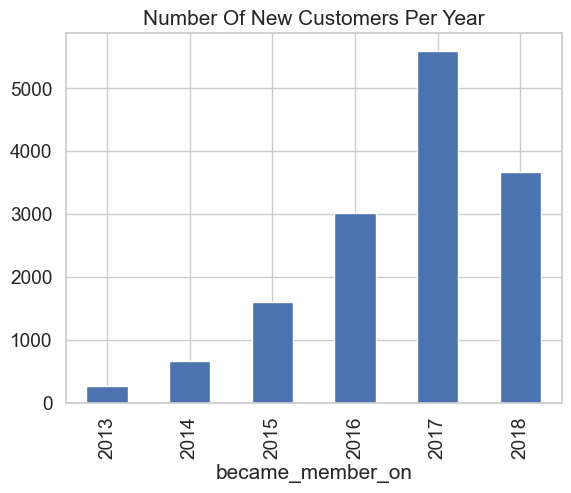

In [28]:
plt.title("Number Of New Customers Per Year")
pd.to_datetime(profile.became_member_on, format='%Y%m%d').dt.year.value_counts().sort_index().plot(kind='bar')
plt.show()

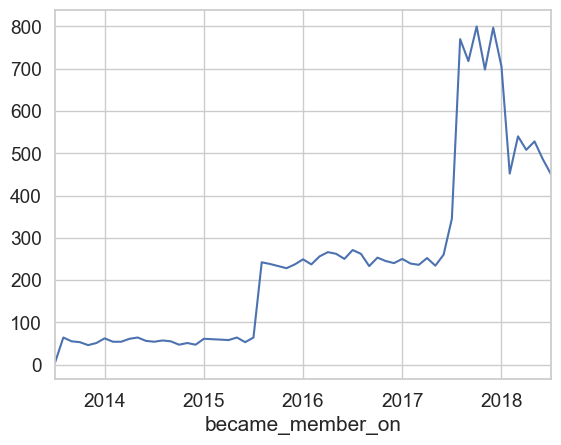

In [29]:
profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count().plot.line()
plt.show()

#### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [30]:
transcript.head() # look into transcript df

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [32]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [33]:
transcript.shape

(306534, 4)

In [34]:
# unique events types
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [35]:
# number of each events
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

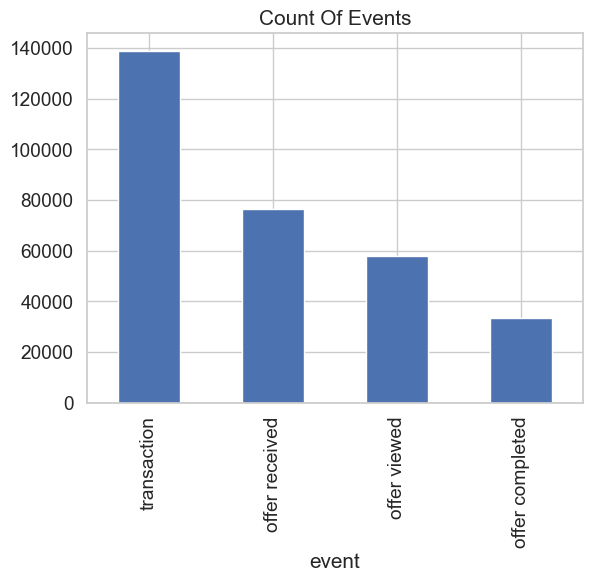

In [36]:
plt.title("Count Of Events")
transcript.event.value_counts().plot(kind='bar')
plt.show()

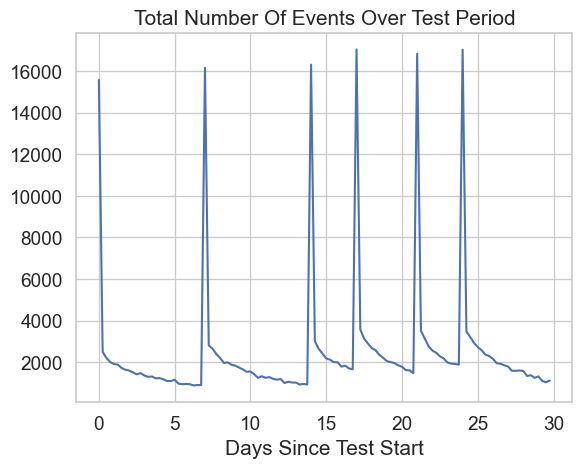

In [37]:
plt.title("Total Number Of Events Over Test Period")
(transcript.time/24).value_counts().sort_index().plot()
plt.xlabel("Days Since Test Start")
plt.show()

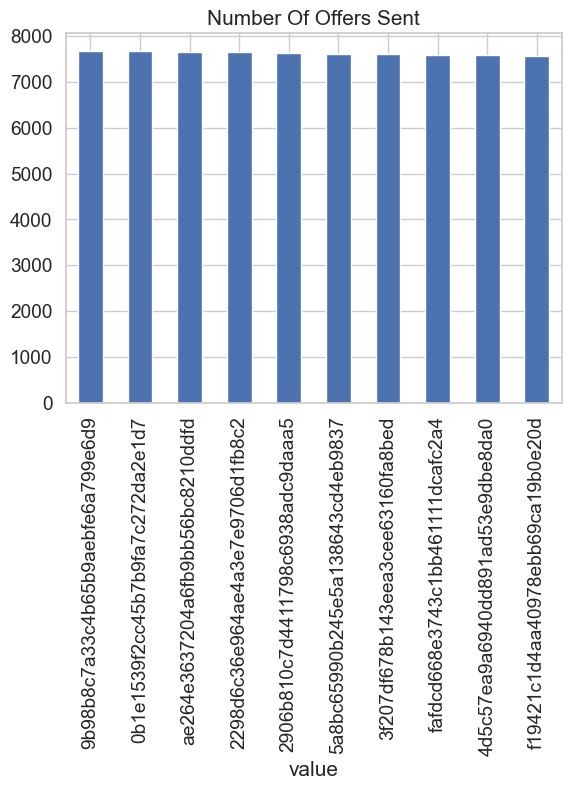

In [38]:
plt.title("Number Of Offers Sent")
transcript.loc[transcript.event=='offer received', 'value'].map(lambda x: x.get('offer id')).value_counts().plot(kind='bar')
plt.show()

In [39]:
# lets keep only data in transcript which has customer id in profile dataframe.

temp2 = transcript['person'].isin(profile['customer_id'])
transcript = transcript[temp2]
print(len(transcript))
transcript.head(7)

272762


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0


In [40]:
""" lets have a separate dataframe which has details about customer id and Amount spent by each customer. 
    I am calling that dataframe moneyspent."""

# amount spent is mentioned for only data with event = transaction, so filtering that.
df_trans = transcript[transcript['event']=='transaction']
moneyspent = pd.DataFrame(data=df_trans)
moneyspent = moneyspent.drop(['value', 'event'], axis = 1)
# taing out amount from value column
moneyspent['amount'] = df_trans['value'].apply(lambda x: list(x.values())[0])
moneyspent = moneyspent.rename(columns = {'person': 'customer_id'})
moneyspent = moneyspent.reset_index(drop=True)
moneyspent.head()


,customer_id,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [41]:
moneyspent = pd.merge(moneyspent, profile[['gender','customer_id']], how='left', on='customer_id')

### Who spends more money (male / female)?

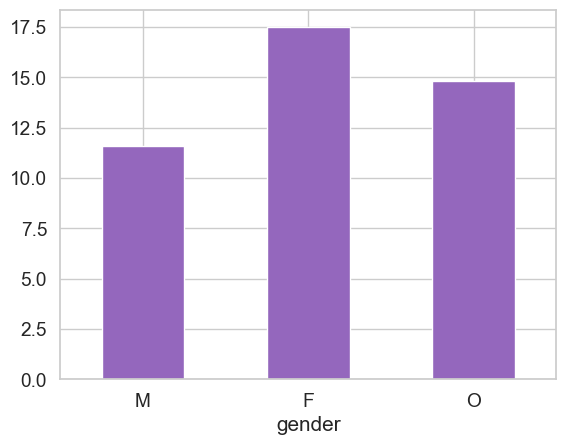

In [42]:
gender_groupby = moneyspent.groupby('gender')
gender_transactions = gender_groupby.amount.count()
gender_expense = gender_groupby.amount.sum()
(gender_expense / gender_transactions).reindex(['M', 'F','O']).plot(kind='bar', rot=0, color='tab:purple');
plt.show()

In [43]:
# unpack information in 'value' column to separate columns
values = transcript['value'].apply(pd.Series)
values.offer_id.fillna(values['offer id'], inplace=True)
transcript = pd.concat([transcript, values], axis=1)
transcript.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_15376\401724482.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  values.offer_id.fillna(values['offer id'], inplace=True)


,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [44]:
# calculate number of offers received per person  and save in num_offers
num_offers = transcript[transcript['event']=='offer received'].groupby('person').count().reset_index()
num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
transcript = pd.merge(transcript, num_offers[['person', 'num_offers']], how='left', on='person')
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,4.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0


In [45]:
# convert event_types categorical variable into indicator variables
event_types = pd.get_dummies(transcript.event)
transcript = pd.concat([transcript, event_types], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward,num_offers,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0,False,True,False,False
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,4.0,False,True,False,False
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0,False,True,False,False
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3.0,False,True,False,False
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,False,True,False,False


In [46]:
# drop and rename columns
transcript.drop(['offer id', 'value', 'reward'], axis=1, inplace=True)
transcript.rename(columns={'person':'customer_id'},inplace=True)
transcript.head(3)

,customer_id,event,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,False,True,False,False
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,False,True,False,False
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,False,True,False,False


In [47]:
""" To know how the event data of each customer look like and which factors need to be addressed during the analysis
lets filter based on 1 customerId """

transcript[transcript['customer_id']=='0009655768c64bdeb2e877511632db8f']

,customer_id,event,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction
49809,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,False,True,False,False
68958,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,False,False,True,False
79398,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,5.0,False,False,False,True
101124,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,5.0,False,True,False,False
124382,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,5.0,False,False,True,False
136377,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,False,True,False,False
149533,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,5.0,False,False,False,True
149534,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,True,False,False,False
166743,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,False,False,True,False
181758,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,5.0,False,True,False,False


In [48]:
# Combine transcript and portfolio data based on offer_id, so that we have one combined data for analysis.
combined = pd.merge(transcript, portfolio, how='left', on='offer_id')
combined.groupby(['offer_type', 'event']).customer_id.count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

In [49]:
combined.head()

,customer_id,event,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction,...,duration,offer_type,email,mobile,social,web,offer,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,False,True,False,False,...,7.0,bogo,1.0,1.0,0.0,1.0,bogo_5_for_5_in_7days,True,False,False
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,False,True,False,False,...,7.0,discount,1.0,1.0,0.0,1.0,discount_2_for_10_in_7days,False,True,False
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,False,True,False,False,...,5.0,bogo,1.0,1.0,1.0,1.0,bogo_5_for_5_in_5days,True,False,False
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,3.0,False,True,False,False,...,4.0,informational,1.0,1.0,0.0,1.0,informational_0_for_0_in_4days,False,False,True
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,False,True,False,False,...,10.0,discount,1.0,0.0,0.0,1.0,discount_5_for_20_in_10days,False,True,False


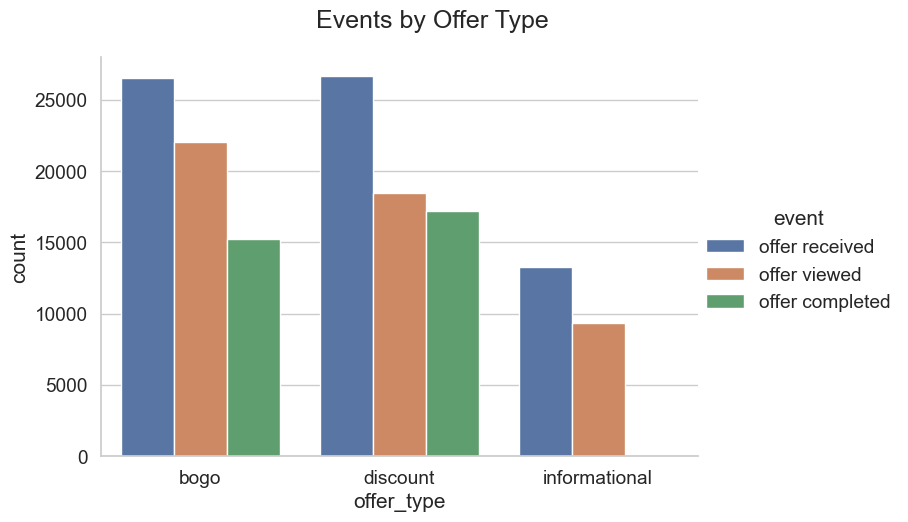

In [50]:
#Plot a graph to see each event by offer_type
events_by_offer_type = sns.catplot(data=combined[combined['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5)
events_by_offer_type.fig.suptitle("Events by Offer Type", y=1.05)
plt.show()

----
## Data Preparation & Processing

To produce reliable model results, further data preparation is essential. Although preliminary data cleaning has been performed, the data is not yet fully optimized for modeling.

To enhance clarity, I will add a dedicated column to categorize outcomes that qualify as successful cases. Since only BOGO and discount offers include "offer completed" events (unlike informational offers), I will prepare the data separately for each offer type, focusing initially on BOGO and discount offers.

#### BOGO and Discount Offers

For BOGO and discount offers, possible customer response paths are outlined as follows:

1. **Successful Offer**: Offer received → offer viewed → transaction(s) → offer completed
2. **Ineffective Offer**: Offer received → offer viewed
3. **Unviewed Offer**: Offer received
4. **Unviewed Success**: Offer received → transaction(s) → offer completed

The "successful offer" path represents the ideal outcome, where the offer is completed after being viewed. Conversely, "ineffective offer" and "unviewed offer" paths denote cases where the offer did not lead to sufficient transactions or none at all, classifying them as unsuccessful.

It is also crucial to distinguish "unviewed success" cases, in which customers completed the offer without viewing it. These customers transacted independently of the offer, underscoring the importance of accurately identifying them to ensure targeted and effective marketing.

Ideally, Starbucks should prioritize customers likely to follow path 1, while deprioritizing those likely to follow paths 2 and 3 (as they are less likely to transact) or path 4 (since these customers would likely purchase without an offer, potentially reducing profit margins if provided discounts).

In [51]:
def prepare_offer_completion(df):
    '''
    cleans dataframe for further analysis based on offer completion
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    combined - the cleaned dataframe
    
    ''' 
    pd.options.mode.chained_assignment = None
    
    # identify success cases in 'offer completed' rows
    offers_completed = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']].sort_values(['customer_id','time'])
    offers_completed = offers_completed[(offers_completed['event']=='offer viewed') | (offers_completed['event']=='offer completed')]
    
    
    # shift() - what this does now shifts first row to next row and put as first row as NaN. way it performs depends on condition.
    # Using this we can filter groups based on customer id and offer_id, and apply shift() to have reference offer_id in column previous_offer_id
    #this is helpful when filtering based on offer completed, so that we get success cond, where offer is completed and that is viewed.
    offers_completed['previous_offer_id'] = offers_completed.groupby(['customer_id', 'offer_id'])['offer_id'].shift()
    
    
    # if offer is completed and if it is viewed then put 1 or else 0 in success column. 
    offers_completed['success'] = np.where((offers_completed['event'] == 'offer completed')
                                           & (offers_completed['previous_offer_id'] == offers_completed['offer_id']),
                                           1, 0)
    # if offer is completed and if it is not viewed then put 1 or else 0 in unviewed success column. 
    offers_completed['unviewed_success'] = np.where((offers_completed['event'] == 'offer completed')
                                                    & (offers_completed['previous_offer_id'].isna()),
                                                    1, 0)
    offers_completed.drop(['previous_offer_id'], axis=1, inplace=True)
    
    # re-include 'offer received' rows
    received_offers = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']][df['event']=='offer received'].sort_values(['customer_id','time'])
    
    together = pd.concat([received_offers, offers_completed]).sort_values(['customer_id', 'time'])
    together = together.sort_values(['customer_id','time'])
    
    # transmit information from 'offer completed' to corresponding 'offer received' rows
    successes = together[(together['event']=='offer received') | (together['event']=='offer completed')]
    successes['success'] = successes.groupby(['customer_id', 'offer_id'])['success'].bfill()
    successes['unviewed_success'] = successes.groupby(['customer_id', 'offer_id'])['unviewed_success'].bfill()
    result = successes[successes['event']=='offer received']
    
    # classify remaining offers as failures and fill missings
    result['failure'] = np.where((result['success'].isna()) & (result['unviewed_success'].isna()), 1, 0)
    # fill missing values with 0
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    
    result['success'] = result['success'].astype('int')
    result['unviewed_success'] = np.where(result['unviewed_success'].isna(), 0, result['unviewed_success'])
    result['unviewed_success'] = result['unviewed_success'].astype('int')
    
    # build categorical outcome column
    result['outcome'] = np.where(result['success'] == 1, 'success',
                                 np.where(result['unviewed_success'] == 1, 'unviewed success', 'failure'))

    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    # add customer and offer information
    combined = pd.merge(result, portfolio, how='left', on='offer_id')
    combined = pd.merge(combined, profile, how='left', on='customer_id')
    combined.drop(['event', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return combined

In [52]:
bogo = combined[combined['offer_type'] == 'bogo']
discount = combined[combined['offer_type'] == 'discount']
bogo_discount_notcleaned = pd.concat([bogo, discount])

In [53]:
bogo_cleaned = prepare_offer_completion(bogo)
discount_cleaned = prepare_offer_completion(discount)
bogo_discount = pd.concat([bogo_cleaned,discount_cleaned])
bogo_discount.head(10)

,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,social,web,offer,bogo,discount,informational,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,bogo_5_for_5_in_5days,True,False,False,M,33,72000.0,2758
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,True,False,False,O,40,57000.0,2495
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,0,bogo_10_for_10_in_7days,True,False,False,F,59,90000.0,3171
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10,...,1,1,bogo_10_for_10_in_5days,True,False,False,F,59,90000.0,3171
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,True,False,False,F,24,60000.0,2919
5,0020ccbbb6d84e358d3414a3ff76cffd,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,True,False,False,F,24,60000.0,2919
6,004b041fbfe44859945daa2c7f79ee64,504,f19421c1d4aa40978ebb69ca19b0e20d,3.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,True,False,False,F,55,74000.0,2376
7,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,1,0,unviewed success,1,10,...,1,0,bogo_10_for_10_in_7days,True,False,False,M,54,99000.0,3144
8,004c5799adbf42868b9cff0396190900,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,True,False,False,M,54,99000.0,3144
9,004c5799adbf42868b9cff0396190900,504,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,True,False,False,M,54,99000.0,3144


In [54]:
def prepare_offer_info_tranx(df):
    '''
    cleans dataframe for further analysis based on transactions within validity period
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    temp3 - the cleaned dataframe
    
    ''' 
    temp3 = df.sort_values(['customer_id','time'])

    # calculate remaining time for offers
    temp3['duration_hrs'] = temp3.duration * 24
    
    # if offer recieved then temp3['time'] + temp3['duration_hrs'] or nan
    temp3['end_time'] = np.where(temp3['event']=='offer received', temp3['time'] + temp3['duration_hrs'], np.nan)
    temp3['end_time'] = temp3.groupby('customer_id')['end_time'].ffill()
    temp3['remaining'] = temp3['end_time'] - temp3.time
    
    temp3['offer'] = np.where((temp3['event']=='transaction') & (temp3['remaining']>=0), temp3['offer'].ffill(), temp3.offer)

    # get rid of all transactions that do not belong to an offer
    temp3 = temp3[-temp3['offer'].isna()]


    # calculate transaction sum during offer validity period using transactions and offer viewed
    temp3_rest = temp3[(temp3['event']=='offer viewed')|(temp3['event']=='transaction')]
    uff = pd.DataFrame(temp3_rest.groupby(['customer_id','offer'])['amount'].sum())
    uff.rename(columns={'amount':'sum'},inplace=True)
    temp3_rest_sum = pd.merge(temp3_rest, uff, how='left', on=['customer_id','offer'])
    temp3_rest_sum['amount'] = np.where(temp3_rest_sum['event']=='offer viewed', temp3_rest_sum['sum'], temp3_rest_sum['amount'])
    temp3 = pd.concat([temp3[temp3['event'] == 'offer received'], temp3_rest_sum]).sort_values(['customer_id', 'time'])
    temp3 = temp3.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # transfer transaction sum to 'offer received' rows
    temp3 = temp3[-(temp3['event']=='transaction')]
    temp3['amount'] = temp3.groupby(['customer_id','offer'])['amount'].shift(-1)
    temp3 = temp3[temp3['event']=='offer received']
    temp3['amount'] = temp3['amount'].fillna(0)
    
    # add success indicator
    temp3['success'] = np.where(temp3['amount']>0,1,0)
    temp3['unviewed_success'] = -99
    temp3['failure'] = -99
    temp3['outcome'] = -99
    temp3['outcome_factor'] = -99
    
    # add customer information
    temp3 = pd.merge(temp3, profile, how='left', on='customer_id')
    temp3.drop(['event', 'became_member_on'], axis=1, inplace=True)

    return temp3

In [55]:
info = combined[(combined['offer_type']=='informational') |(combined['event']=='transaction')]

In [56]:
info_cleaned = prepare_offer_info_tranx(info)
info_cleaned.head(10)

,customer_id,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction,reward,...,informational,success,unviewed_success,failure,outcome,outcome_factor,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,168,22.16,5a8bc65990b245e5a138643cd4eb9837,5.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,M,33,72000.0,2758
1,0009655768c64bdeb2e877511632db8f,336,8.57,3f207df678b143eea3cee63160fa8bed,5.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,M,33,72000.0,2758
2,0011e0d4e6b944f998e987f904e8c1e5,0,0.00,3f207df678b143eea3cee63160fa8bed,5.0,False,True,False,False,0.0,...,True,0,-99,-99,-99,-99,O,40,57000.0,2495
3,0011e0d4e6b944f998e987f904e8c1e5,336,0.00,5a8bc65990b245e5a138643cd4eb9837,5.0,False,True,False,False,0.0,...,True,0,-99,-99,-99,-99,O,40,57000.0,2495
4,0020c2b971eb4e9188eac86d93036a77,504,51.10,5a8bc65990b245e5a138643cd4eb9837,5.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,F,59,90000.0,3171
5,0020ccbbb6d84e358d3414a3ff76cffd,408,58.87,5a8bc65990b245e5a138643cd4eb9837,4.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,F,24,60000.0,2919
6,003d66b6608740288d6cc97a6903f4f0,0,2.51,5a8bc65990b245e5a138643cd4eb9837,5.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,F,26,73000.0,2697
7,003d66b6608740288d6cc97a6903f4f0,336,12.27,3f207df678b143eea3cee63160fa8bed,5.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,F,26,73000.0,2697
8,00426fe3ffde4c6b9cb9ad6d077a13ea,0,25.92,5a8bc65990b245e5a138643cd4eb9837,5.0,False,True,False,False,0.0,...,True,1,-99,-99,-99,-99,F,19,65000.0,3013
9,004b041fbfe44859945daa2c7f79ee64,168,0.00,3f207df678b143eea3cee63160fa8bed,3.0,False,True,False,False,0.0,...,True,0,-99,-99,-99,-99,F,55,74000.0,2376


In [57]:
'''
With the data for all offer types now cleaned and enriched with a binary indicator for offer success, it can be combined into a single dataset. 
This dataset will then be used to build the classification model.
'''

info_test = info_cleaned.drop(columns=['amount'])
full_data = pd.concat([bogo_discount,info_test])
full_data.head()

,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,discount,informational,gender,age,income,membership_duration,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5.0,...,False,False,M,33,72000.0,2758,NaN,NaN,NaN,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5.0,...,False,False,O,40,57000.0,2495,NaN,NaN,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10.0,...,False,False,F,59,90000.0,3171,NaN,NaN,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10.0,...,False,False,F,59,90000.0,3171,NaN,NaN,NaN,NaN
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5.0,...,False,False,F,24,60000.0,2919,NaN,NaN,NaN,NaN


In [58]:
full_data=full_data.fillna(0);
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66501 entries, 0 to 13299
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          66501 non-null  object 
 1   time                 66501 non-null  int64  
 2   offer_id             66501 non-null  object 
 3   num_offers           66501 non-null  float64
 4   success              66501 non-null  int32  
 5   unviewed_success     66501 non-null  int64  
 6   failure              66501 non-null  int64  
 7   outcome              66501 non-null  object 
 8   outcome_factor       66501 non-null  int64  
 9   reward               66501 non-null  float64
 10  difficulty           66501 non-null  float64
 11  duration             66501 non-null  float64
 12  offer_type           66501 non-null  object 
 13  email                66501 non-null  float64
 14  mobile               66501 non-null  float64
 15  social               66501 non-null  floa

C:\Users\HP\AppData\Local\Temp\ipykernel_15376\1915807598.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data=full_data.fillna(0);


## Which offer demonstrates greater success?

In [59]:
print('The total counts of different events for BOGO offer is')
print(bogo.event.value_counts())

print('\n\nThe total counts of different events for discount offer is')
print(discount.event.value_counts())

The total counts of different events for BOGO offer is
event
offer received     26537
offer viewed       22039
offer completed    15258
Name: count, dtype: int64


The total counts of different events for discount offer is
event
offer received     26664
offer viewed       18461
offer completed    17186
Name: count, dtype: int64


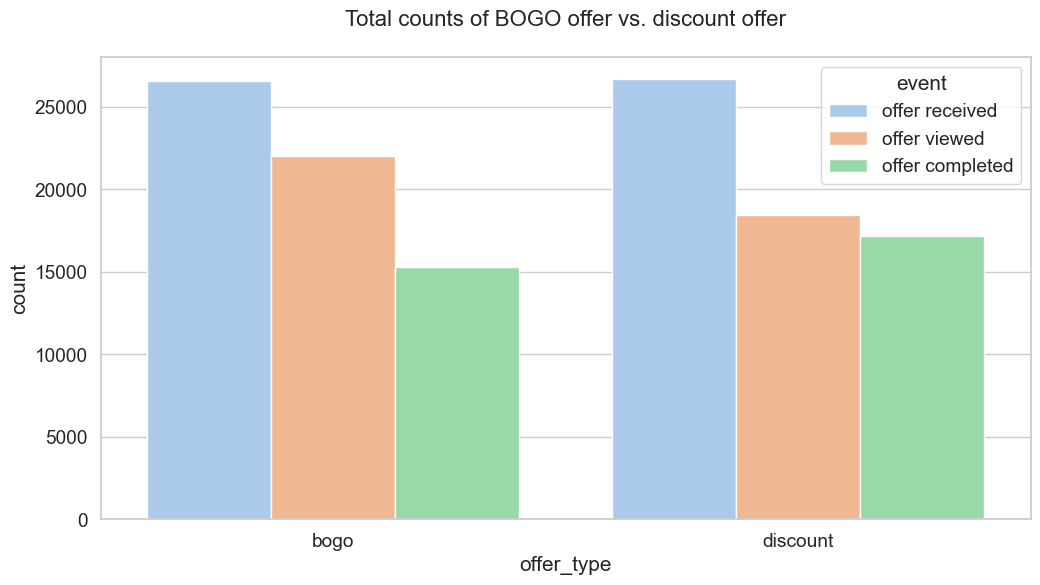

In [60]:
""" for analysis lets plot graph with counts for Total counts of BOGO offer vs. discount offer1 """

fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type", hue="event", data=bogo_discount_notcleaned, palette="pastel")
plt.title("Total counts of BOGO offer vs. discount offer\n", fontsize=16)
plt.show();

In [61]:
def event_counts(df):
    """
    output:
    returns the counts of each individual event
    Input:
    df: dataframe
    """
    events = df['event'].unique()
    counts = []
    for event in events:
        count = len(df[df['event'] == event])
        yield count

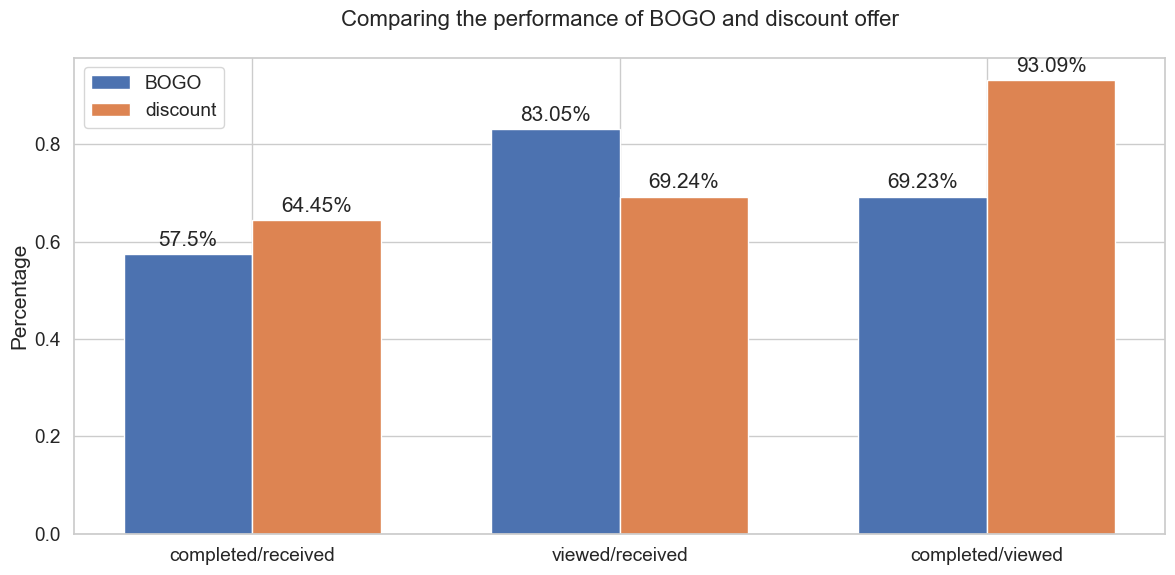

In [62]:
#event counts of BOGO offer
bogo_received, bogo_viewed, bogo_completed = event_counts(bogo)

#event counts of discount offer
discount_received, discount_viewed, discount_completed = event_counts(discount)

labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo_completed/bogo_received, bogo_viewed/bogo_received, bogo_completed/bogo_viewed]
discount_performance = [discount_completed/discount_received, discount_viewed/discount_received, discount_completed/discount_viewed]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offer\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

## The discount offer demonstrates a higher success rate because

The absolute count of 'offer completed' is marginally higher for discount offers compared to BOGO offers, and the overall completion-to-receipt ratio is approximately 7% greater for discounts. However, BOGO offers exhibit a significantly higher likelihood of being viewed by customers. Nonetheless, converting an offer receipt into a successful completion appears more achievable with discount offers than with BOGO offers.

Additionally, we can examine offers that followed the successful engagement path:
offer received → offer viewed → transaction(s) → offer completed.

In [63]:
pd.DataFrame(full_data.groupby(['offer'])['success'].mean()).reset_index().sort_values('success', ascending=False)

,offer,success
4,discount_2_for_10_in_10days,0.691371
6,discount_3_for_7_in_7days,0.665214
8,informational_0_for_0_in_3days,0.640373
2,bogo_5_for_5_in_5days,0.563108
0,bogo_10_for_10_in_5days,0.457455
1,bogo_10_for_10_in_7days,0.435583
9,informational_0_for_0_in_4days,0.382605
3,bogo_5_for_5_in_7days,0.374869
5,discount_2_for_10_in_7days,0.367667
7,discount_5_for_20_in_10days,0.243533


##### This further illustrates that the discount offer outperforms the BOGO offer.

## Predicting Offer Success

Following initial data exploration and cleaning, along with addressing a few key questions, the next objective is to develop a basic machine learning model to predict offer success based on the characteristics of the offer and the customer.

The evaluation metrics employed will include `accuracy_score` and `roc_auc_score`.

In [64]:
def Classification_model(df, target, target_names,
                               model=RandomForestClassifier(max_depth=20, random_state=42)):
    '''
    Builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable
    target_names - labels for the target values
    model - the model (default: random forest classification with max tree depth of 20, random state of 42)
    
    OUTPUT:
    model - the classification model
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    model = model

    model.fit(X_train, y_train)
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions, target_names=target_names))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
    
    return model

In [65]:
overall_model_randf = Classification_model(full_data, 'success', ['failure', 'success'])

              precision    recall  f1-score   support

     failure       0.72      0.71      0.71     10390
     success       0.69      0.70      0.69      9561

    accuracy                           0.70     19951
   macro avg       0.70      0.70      0.70     19951
weighted avg       0.70      0.70      0.70     19951

Overall model accuracy:	 0.7031727732945717
Train ROC AUC score:	 0.996143780340031
Test ROC AUC score:	 0.7678192325475275


In [66]:
overall_model_gb = Classification_model(full_data, 'success', ['failure', 'success'],GradientBoostingClassifier(random_state=42))

              precision    recall  f1-score   support

     failure       0.69      0.71      0.70     10390
     success       0.68      0.66      0.67      9561

    accuracy                           0.69     19951
   macro avg       0.69      0.68      0.68     19951
weighted avg       0.69      0.69      0.69     19951

Overall model accuracy:	 0.6857300385945566
Train ROC AUC score:	 0.7545997663725021
Test ROC AUC score:	 0.7526661639426049


In [67]:
overall_model = Classification_model(full_data, 'success', ['failure', 'success'],AdaBoostClassifier(random_state=42))

C:\Users\HP\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

     failure       0.68      0.68      0.68     10390
     success       0.66      0.66      0.66      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy:	 0.6710941807428199
Train ROC AUC score:	 0.7295966493333714
Test ROC AUC score:	 0.7299133701950669


In [68]:
overall_model.get_params()

{'algorithm': 'SAMME.R',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [70]:
param_grid={'n_estimators': [50, 100, 500],
            'learning_rate': [0.1,0.7, 1],
             'algorithm': ['SAMME.R','SAMME']}

cv = GridSearchCV(overall_model, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc')

full_data_prep = full_data.dropna(how='any', axis=0)    
gender = pd.get_dummies(full_data_prep.gender)
full_data_prep = pd.concat([full_data_prep, gender], axis=1)

X = full_data_prep.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
y = full_data_prep.pop('success')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

score = cv.fit(X_train, y_train)

score.best_params_

C:\Users\HP\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}

In [71]:
opt_model = AdaBoostClassifier(n_estimators=500,learning_rate=0.1,algorithm='SAMME.R',random_state=42)
model_opt = Classification_model(full_data, 'success', ['failure', 'success'], model=opt_model)

C:\Users\HP\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

     failure       0.68      0.68      0.68     10390
     success       0.65      0.66      0.65      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy:	 0.6689890231066112
Train ROC AUC score:	 0.7295248849870593
Test ROC AUC score:	 0.7302833968483006


In [72]:
def most_important_features(df, model):
    '''
    identifies most important features
    
    INPUT:
    df - the dataframe used to train and test the model
    model - the classification model
    
    OUTPUT:
    feat_imp - an ordered dataframe consisting of all features and importance
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
    
    feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns,
                            columns=['importance']).sort_values('importance', ascending=False).reset_index()
    feat_imp.rename(columns={'index':'feature'},inplace=True)

    colors = sns.color_palette("Set2", len(feat_imp))  # Generate a list of colors from Set2 palette
    
    plot = sns.catplot(data=feat_imp.reset_index(), y='feature', x='importance', kind='bar', aspect=2, hue='feature', palette=colors)
    plot.set(title='Feature importance')
    plt.show()
    
    return feat_imp

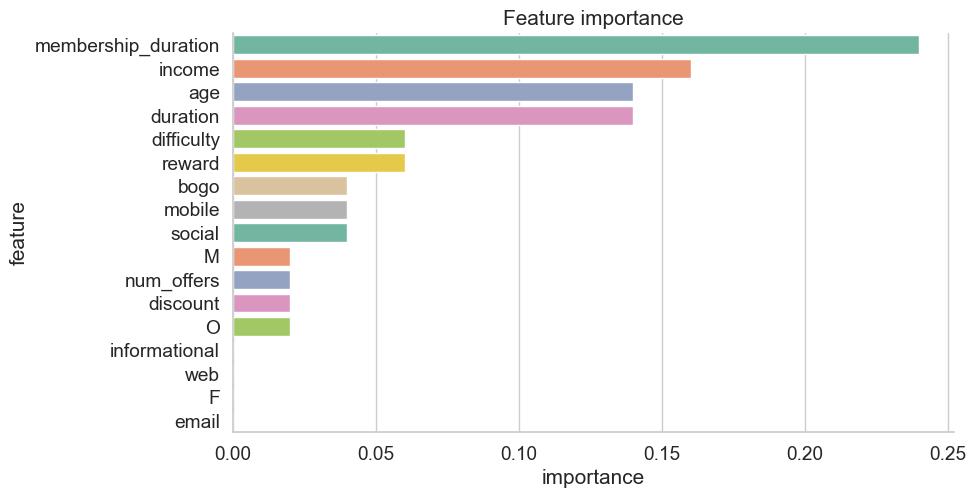

,feature,importance
0,membership_duration,0.24
1,income,0.16
2,age,0.14
3,duration,0.14
4,difficulty,0.06
5,reward,0.06
6,bogo,0.04
7,mobile,0.04
8,social,0.04
9,M,0.02


In [73]:
most_important_features(full_data, overall_model)

##### The most influential factors in my model are membership duration, income, age, and offer duration.**

In [74]:
# Total number of received offers
full_data.groupby(['num_offers'])['success'].mean()

num_offers
1.0    0.532258
2.0    0.479323
3.0    0.478468
4.0    0.471573
5.0    0.487841
6.0    0.484353
Name: success, dtype: float64

##### Offer success exhibits a U-shaped relationship with the total number of received offers, tending to be higher when the count is either very low or very high. This pattern may, however, be coincidental.

In [75]:
full_data.groupby('success')['income'].mean()

success
0    63151.442168
1    67759.699117
Name: income, dtype: float64

In [76]:
full_data.groupby(['social'])['success'].mean()

social
0.0    0.341923
1.0    0.575599
Name: success, dtype: float64

##### Offers are more likely to achieve success when delivered through the 'social' channel.

## Conclusion

### Results

The objective of this project was to predict the success of offers based on available offer and customer data. For this purpose, a classification model was developed, experimenting with various algorithms such as Random Forest, Gradient Boosting, and AdaBoost classifiers. Among these, the AdaBoost classifier yielded the best results for this particular dataset.

The AdaBoost model demonstrated a predictive accuracy of 67%, a reasonable level for business application, though there remains potential for enhancement.

Key factors identified by the model as influencing offer success include:
- Membership duration
- Income
- Age
- Offer duration

### Insights

During the model development process, a few key questions were explored and addressed:

1. **Which type of offer is the most successful?**  
   Discount offers emerged as more successful compared to BOGO offers. While BOGO offers have a higher likelihood of being seen by customers, discount offers exhibit a slightly higher completion rate (approximately 7% more) and a better conversion from "offer received" to "offer completed."

2. **Who spends more: males or females?**  
   Analysis of expenditure data indicates that female customers tend to spend more, which could be useful in customer targeting strategies for brands like Starbucks.

### Opportunities for Improvement/Future Scope

To enhance model performance, future improvements could include:
- Experimenting with advanced modeling techniques and algorithms.
- Implementing imputation strategies for handling missing values rather than omitting observations, as this could provide more comprehensive insights and improve model accuracy.